In [1]:
import warnings

import numpy as np
from matplotlib import pyplot as plt
import sklearn
import mglearn

warnings.filterwarnings('ignore')

/home/inory/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/inory/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 使用MinMaxScaller 缩放数据、并使用SVC分类

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaller = MinMaxScaler().fit(X_train)

X_train_scalled = scaller.transform(X_train)
X_test_scalled = scaller.transform(X_test)

svm = SVC().fit(X_train_scalled, y_train)

print('Score of svm', svm.score(X_test_scalled, y_test))

Score of svm 0.951048951048951


# 使用网格搜索选择参数

In [3]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scalled, y_train)

print('Best cross validation score:', grid.best_score_)
print('Best test score:', grid.score(X_test_scalled, y_test))
print('Best parameters:', grid.best_params_)

Best cross validation score: 0.9812206572769953
Best test score: 0.972027972027972
Best parameters: {'C': 1, 'gamma': 1}


上述方法的缺陷在于:

- 使用所有的X_train 给 Scaller
- Scaller后的数据不仅仅用于训练，也用于验证
- 验证集仅供调参，不能将信息提供给MinMaxscaler
- 可能使结果偏向乐观，不能提供准确的参数选择

# 管道的使用

## 简单的管道分类

In [4]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaller', MinMaxScaler()), ('svm', SVC())])
pipe.fit(X_train, y_train)
print('Test score:', pipe.score(X_test, y_test))

Test score: 0.951048951048951


## 管道作为网格搜索的估计器

In [5]:
# 管道作为估计器时需要指定参数对应的操作
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross validation score:', grid.best_score_)
print('Best test score:', grid.score(X_test, y_test))
print('Best parameters:', grid.best_params_)

Best cross validation score: 0.9812206572769953
Best test score: 0.972027972027972
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


## 测试集信息泄露的例子

In [6]:
# 构造数据集
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

# 对全部信息进行特征提取，回归预测
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print('X_select shape', X_selected.shape)

# 进行交叉验证
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print('Cross val score:', cross_val_score(Ridge(), X_selected, y, cv=5))

# 使用管道处理特征选择,在管道内部使用特征选择， 只通过训练集获取特征选择器
pipe = Pipeline([('select', SelectPercentile(score_func=f_regression, percentile=5)),
                 ('ridge', Ridge())])
print('Cross validation score:', cross_val_score(pipe, X, y, cv=5))

X_select shape (100, 500)
Cross val score: [0.84834054 0.94084243 0.88541709 0.94012139 0.91425508]
Cross validation score: [-0.97502994 -0.03166358 -0.03989415  0.03018385 -0.2163673 ]


# 通用的管道接口

## 管道内部原理

- 可以将任意数量的estimator连接在一起，例如可以构建一个包含特征提取、特征选择、缩放、和分类的管道。
- 在 `Pipline.fit()`中, 在最后一步之前，顺序调用fit 和transform，前一步的输入作为后一步的输出，在最后一步只调用fit。
- 在 `Pipline.predict()`中， 在最后一步之前，顺序调用transform，前一次的输入作为后一步的输出，在最后一步只调用predict。

In [7]:
# fit 过程，和源代码流程相同，写法不同
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 遍历除了最后一步外的所有步骤
        # 对数据进行拟合和变换
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 对最后一步进行拟合
    self.steps[-1][1].fit(X_transformed, y)
    return self

# predict 过程， 同上
def predict(self, X):
    X_transformed = X
    for step in self.steps[: -1]:
        # 遍历最后一步之前的所有步骤
        # 对每一步进行变换
        X_transformed = step[1].transform(X_transformed)
    # 对最后一步进行预测
    return self.steps[-1][1].predict(X_transformed)

## 使用make_pipeline方便地创建管道

In [8]:
from sklearn.pipeline import make_pipeline

# 标准语法
pipe_long = Pipeline([('scaller', MinMaxScaler()), ('svm', SVC(C=100))])
# 缩写语法
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

print('print pipeline steps:\n',pipe_short.steps)

print pipeline steps:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


一般情况下，步骤的名称为类名称的小写，当有多个相同的类对象时，步骤名称加一个编号区分，此时使用标准语法手动设置步骤名称比较好

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('Pipeline steps:')
import pprint
pprint.pprint(pipe.steps)

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


## 访问步骤属性

In [10]:
# 使用之前的管道进行拟合
pipe.fit(cancer.data)
print('pca components shape:', pipe.named_steps['pca'].components_.shape)

pca components shape: (2, 30)


## 应用于网格搜索的例子

In [11]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best score:', grid.best_score_)
print('Best estimator:\n', grid.best_estimator_)
print("Logistic regression step:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"]))
print("Logistic regression coefficients:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"].coef_))

Best score: 0.9788732394366197
Best estimator:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=N

## 管道与网格搜索调参

使用管道重复波士顿数据处理中的三个步骤：缩放数据、计算多项式特征、岭回归

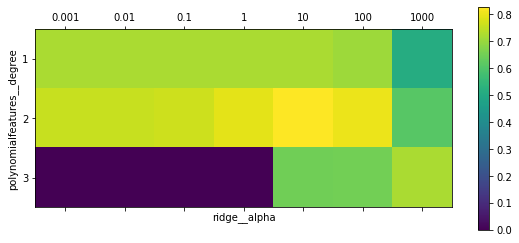

Best parameters:  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test set score: 0.7683045464100131


In [12]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# 创建网格搜索
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
# 可视化交叉验证的结果
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap='viridis')
plt.xlabel('ridge__alpha')
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
    param_grid['polynomialfeatures__degree'])
plt.colorbar()
plt.show()

print('Best parameters: ', grid.best_params_)
print('Test set score:', grid.score(X_test, y_test))

作为对比，运行一个没有多项式特征的网格搜索

In [13]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


### 比较不同的类效果

In [18]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

# svc 情况下，参数包括缩放添加或不添加两种情况，以及gamma、C的设置
# rf 情况下， 不加预处理方法，参数为classifier__max_features
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}
]

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98
